In [1]:
# Copyright (c) 2015-2016, the authors (see AUTHORS.txt).
# Licensed under the BSD 3-clause license (see LICENSE.txt)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook

import unittest
import deepgp
import GPy
import os
import h5py
import tables

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs
from sklearn.decomposition import PCA
import scipy

base_path = os.path.dirname("__file__")

In [2]:
# def const(x):
#     x = tf.constant(x,dtype=tf.float32)
#     return x

# plt.subplots(2,3,figsize=(10,6))

# def build_toy_dataset(N, D, K, Ngrid = 100, prior_l=2, prior_sig_f=1, l=0.5, sig_f=1, sig_n=1e-1):
#     Nall = Ngrid + N
#     tgrid = np.linspace(-5, 5, num=N).reshape(-1,1)

#     sess = ed.get_session()
#     with sess.as_default():
#         Kprior = rbf(const(tgrid),lengthscale=const(prior_l),variance=const(prior_sig_f)).eval()

#     z_mu = np.zeros(N)
#     z_cov = Kprior + 1e-10*np.eye(N)
#     z = np.random.multivariate_normal(z_mu, z_cov).T.reshape(-1,1)
#     zgrid = np.linspace(z.min(), z.max(), num=Ngrid).reshape(-1,1)
#     zall = np.vstack((z,zgrid))

#     plt.subplot(2,3,1)
#     plt.imshow(Kprior)
#     plt.colorbar()
#     plt.subplot(2,3,2)
#     plt.plot(z)

#     with sess.as_default():
#         Kzall = rbf(const(zall),lengthscale=const(l),variance=const(sig_f)).eval()

#     Kz = Kzall[:N,:N]
#     xall = np.random.multivariate_normal(np.zeros(Nall), Kzall, D).T
#     x = xall[:N,:]
#     xgrid = xall[N:,:]
#     noise = np.random.randn(x.shape[0],x.shape[1])
#     x = x + sig_n*noise

#     plt.subplot(2,3,4)
#     plt.imshow(Kz)
#     plt.colorbar()
#     plt.subplot(2,3,5)
#     plt.imshow(np.cov(x))
#     plt.colorbar()
#     plt.subplot(2,3,6)
#     plt.plot(xgrid[:,:5])

#     return x,xgrid,z,zgrid,tgrid,Kz,Kprior

# N = 500  # number of data points, number of time points
# D = 200  # data dimensionality, number of neurons
# K = 1  # latent dimensionality

# x_true, xgrid, z_true, zgrid, tgrid, Kz_true, Kprior_true = build_toy_dataset(N, D, K)

# print("Number of data points N={}".format(N))
# print("Number of features D={}".format(D))
# print("Number of latent dimensions K={}".format(K))

# pca = PCA(n_components=1)
# z_init = pca.fit_transform(x_true)

# # visualize the covariance of Z
# plt.subplot(2,3,3)
# plt.plot(z_init)

# scipy.io.savemat('syn.mat',mdict={'x_true':x_true, 'xgrid':xgrid, 'z_true':z_true, 'zgrid':zgrid, 
#                                   'tgrid':tgrid, 'Kz_true':Kz_true, 'Kprior_true':Kprior_true})

<IPython.core.display.Javascript object>


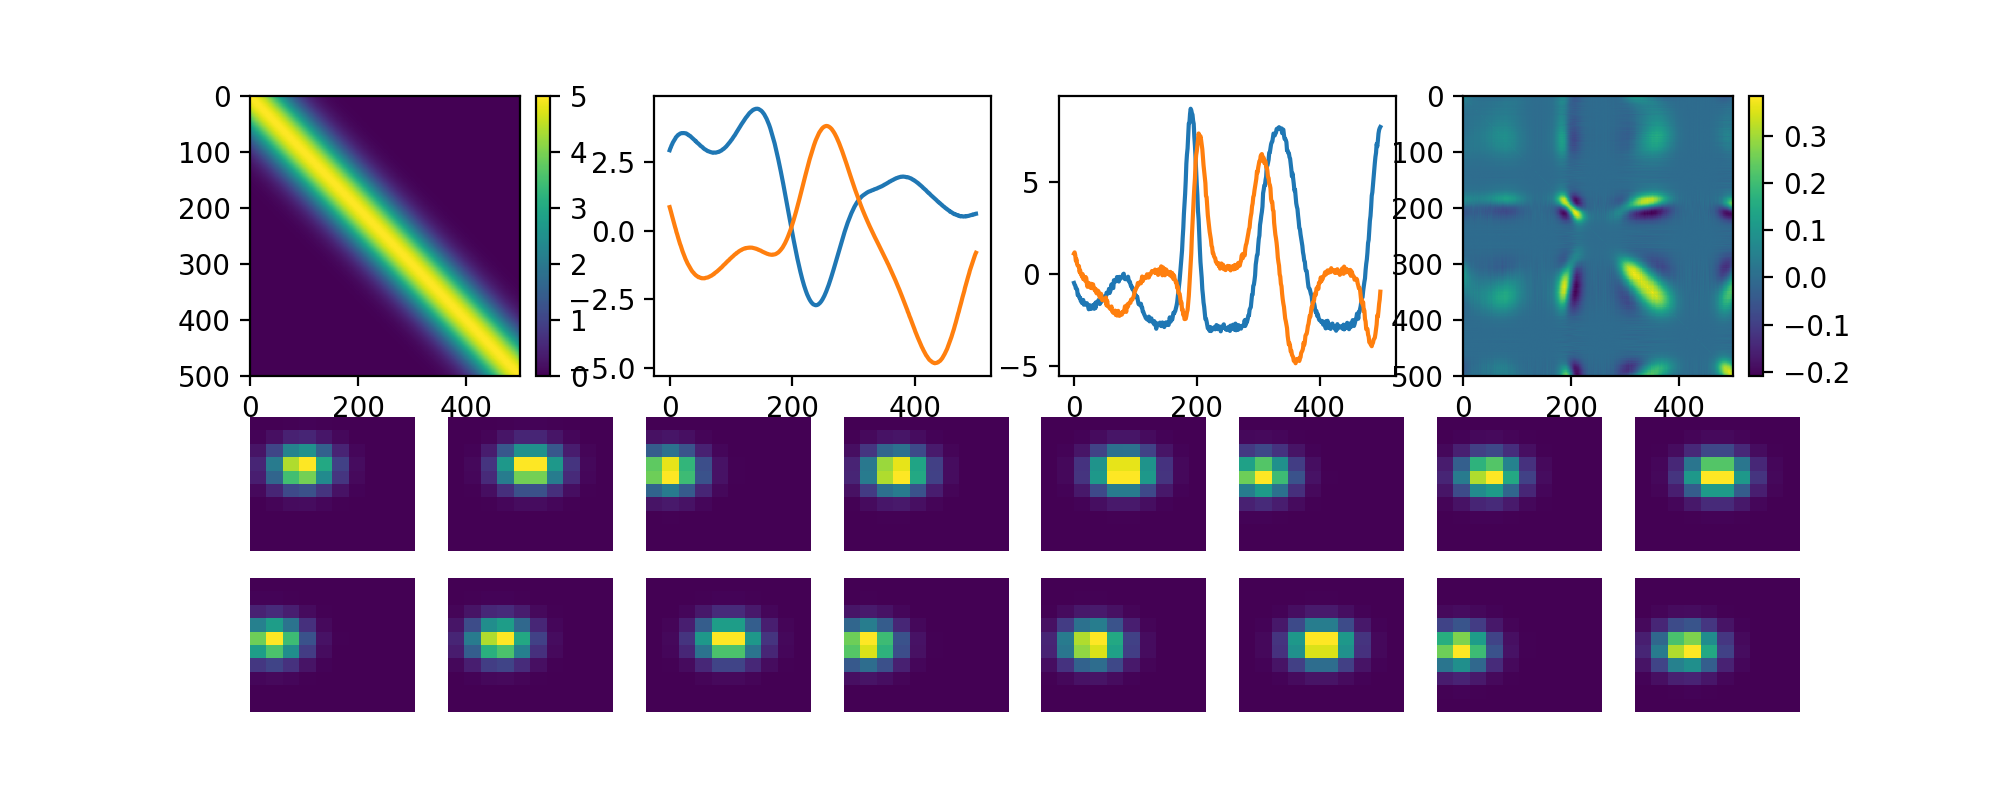

Number of data points N=500
Number of features D=200
Number of latent dimensions K=2


In [3]:
data = scipy.io.loadmat('syn2d.mat')
x_true = data['x_true']
xgrid = data['xgrid']
z_true = data['z_true']
zgrid = data['zgrid']
tgrid = data['tgrid']
Kz_true = data['Kz_true']
Kprior_true = data['Kprior_true']

N = x_true.shape[0]
D = x_true.shape[1]
K = z_true.shape[1]
Ngrid = int(np.sqrt(xgrid.shape[0]))

pca = PCA(n_components=K)
z_init = pca.fit_transform(x_true)

plt.subplots(4,8,figsize=(10,4))
plt.subplot(2,4,1)
plt.imshow(Kprior_true,aspect='auto')
plt.colorbar()
plt.subplot(2,4,2)
plt.plot(z_true)

# visualize the covariance of Z
plt.subplot(2,4,3)
plt.plot(z_init)

extent = z_true[:,0].min(), z_true[:,0].max(), z_true[:,1].min(), z_true[:,1].max()
plt.subplot(2,4,4)
plt.imshow(np.cov(x_true),aspect='auto')
plt.colorbar()

for i in range(16):
    plt.subplot(4,8,i+17)
    plt.imshow(xgrid[:,i*5+20].reshape(Ngrid,Ngrid),extent=extent,aspect='auto')
    plt.axis('off')
    
print("Number of data points N={}".format(N))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))

In [6]:
m = GPy.models.GPLVM(x_true, K, init='random', kernel=GPy.kern.RBF(K, lengthscale=1, ARD=False))
print(m)
m['Gaussian_noise.variance'].fix()
m.optimize(max_iters=300)
print(m)
m['Gaussian_noise.variance'].constrain_positive()
m.optimize(max_iters=50)
print(m)


Name : GPLVM
Objective : 104187.28594528508
Number of Parameters : 1003
Number of Optimization Parameters : 1003
Updates : True
Parameters:
  GPLVM.                   |     value  |  constraints  |  priors
  latent_mean              |  (500, 2)  |               |        
  rbf.variance             |       1.0  |      +ve      |        
  rbf.lengthscale          |       1.0  |      +ve      |        
  Gaussian_noise.variance  |       1.0  |      +ve      |        


 /Users/anqiwu/anaconda/envs/vae-tutorial/lib/python3.6/site-packages/GPy-1.8.0-py3.6-macosx-10.7-x86_64.egg/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square



Name : GPLVM
Objective : 95266.57307881795
Number of Parameters : 1003
Number of Optimization Parameters : 1002
Updates : True
Parameters:
  GPLVM.                   |           value  |  constraints  |  priors
  latent_mean              |        (500, 2)  |               |        
  rbf.variance             |  0.418208836457  |      +ve      |        
  rbf.lengthscale          |   169.360330315  |      +ve      |        
  Gaussian_noise.variance  |             1.0  |   +ve fixed   |        

Name : GPLVM
Objective : -76218.54666816312
Number of Parameters : 1003
Number of Optimization Parameters : 1003
Updates : True
Parameters:
  GPLVM.                   |           value  |  constraints  |  priors
  latent_mean              |        (500, 2)  |               |        
  rbf.variance             |  0.285542432994  |      +ve      |        
  rbf.lengthscale          |   88.0033729645  |      +ve      |        
  Gaussian_noise.variance  |  0.010279982044  |      +ve      |        

<IPython.core.display.Javascript object>


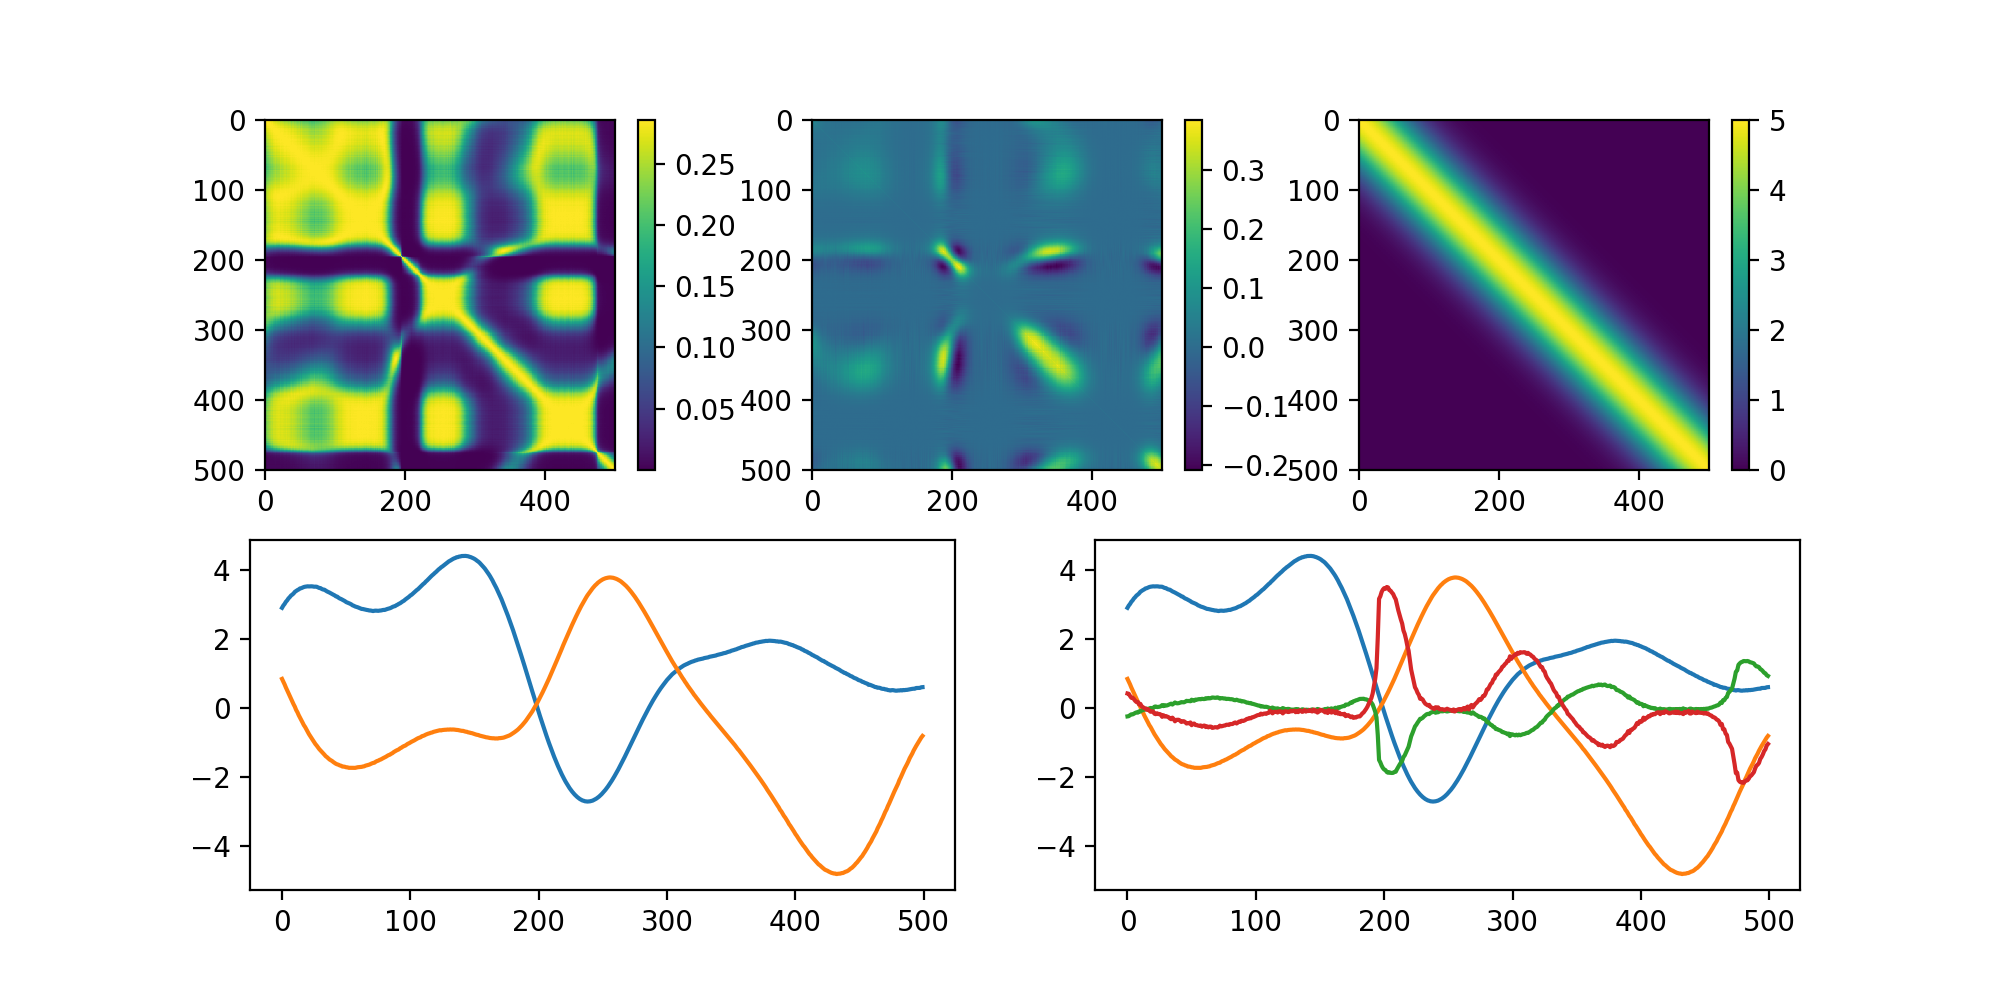

In [7]:
Kz = m.kern.K(m.X, m.X)

def align_z(x,z):
    wgt = np.linalg.lstsq(x-x.mean(), z-z.mean())[0]   
    xx = np.dot(x-x.mean(),wgt)
    return xx
    
plt.subplots(2,3,figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(Kz)
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,2,3)
plt.plot(z_true)
plt.subplot(2,2,4)
plt.plot(z_true)
plt.plot(align_z(m.X,z_true))
